# Group No 254


#### Team Members:-

- Piyush Mehar - 20BCE10065 - piyush.mehar2020@vitbhopal.ac.in


- Anubhav Shukala - 20BCE10708 - anubhavshukla.2020@vitbhopal.ac.in

------------------------------

# Introduction


Customer churn (also known as customer attrition) occurs when a customer stops using a company's products or services.

Customer churn has an impact on profitability, particularly in sectors where subscription-based revenue models are prevalent (e.g., banks, phone and internet service providers, pay-TV providers, insurance companies, etc.). According to estimates, it might cost up to five times as much to get a new customer as it does to keep a current one.

Therefore, customer churn analysis is essential as it can help a business:

- Identify issues with its services (such as poor product or service quality, inadequate customer support, the incorrect target market, etc.), and
- making sound strategic choices that will increase customer happiness and, as a result, client retention.

<br>

# Objective

The goal of this notebook is to understand and predict customer churn for a bank. Specifically, we will initially perform **Exploratory Data Analysis** (**EDA**) to identify and visualise the factors contributing to customer churn. This analysis will later help us build **Machine Learning** models to predict whether a customer will churn or not. 

This problem is a typical **classification** task. The task does not specify which performance metric to use for optimising our machine learning models. I decided to use **recall** since correctly classifying elements of the positive class (customers who will churn) is more critical for the organization.

<br>

*Skills: Exploratory Data Analysis, Data Visualisation, Data Preprocessing (Feature Selection, Encoding Categorical Features, Feature Scaling), Addressing Class Imbalance (SMOTE)*

*Models Used: DecisionTree, Random Forests, Gradient Boosting, XGBoost, and Light Gradient Boosting Machine.*


<br>

## Importing all the required libraries

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE


## Reading the dataset
We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [94]:
df = pd.read_csv('Churn_Modelling.csv')

In [95]:
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [96]:
df.shape

(10000, 14)

Our DataFrame has 14 features and 10K instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [97]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print(df.shape)
print(df.columns)

(10000, 11)
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


### Analyzing the dataset

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [99]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The most important things to note are:

- The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
- The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3), and
- Approximately 50% of customers are active.

EDA will help us understand our dataset better. However, before we look at the data any further, we need to create a **test set**, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from **data snooping bias** 

Now we are checking the null value in the dataset

In [100]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Outliers

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

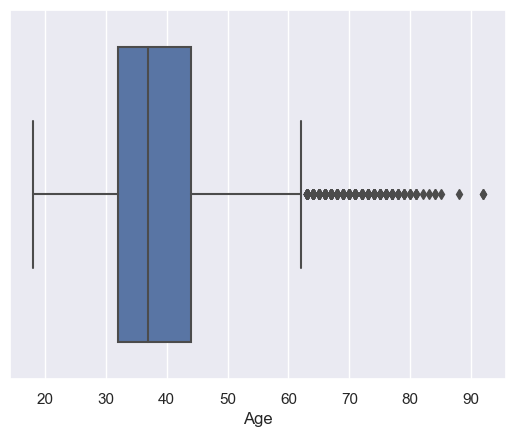

In [101]:
sns.boxplot(df.Age)

In [114]:
perc99=df.Age.quantile(0.99)
perc99


56.0

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

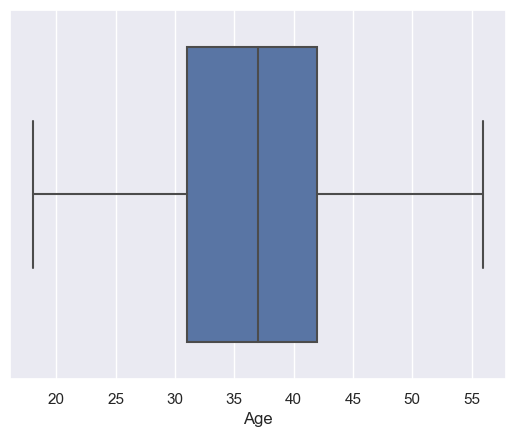

In [116]:
df=df[df.Age<=perc99]
sns.boxplot(df.Age)

<br>

# Exploratory Data Analysis

As we mentioned earlier, the target variable is already encoded and can take two possible values:

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

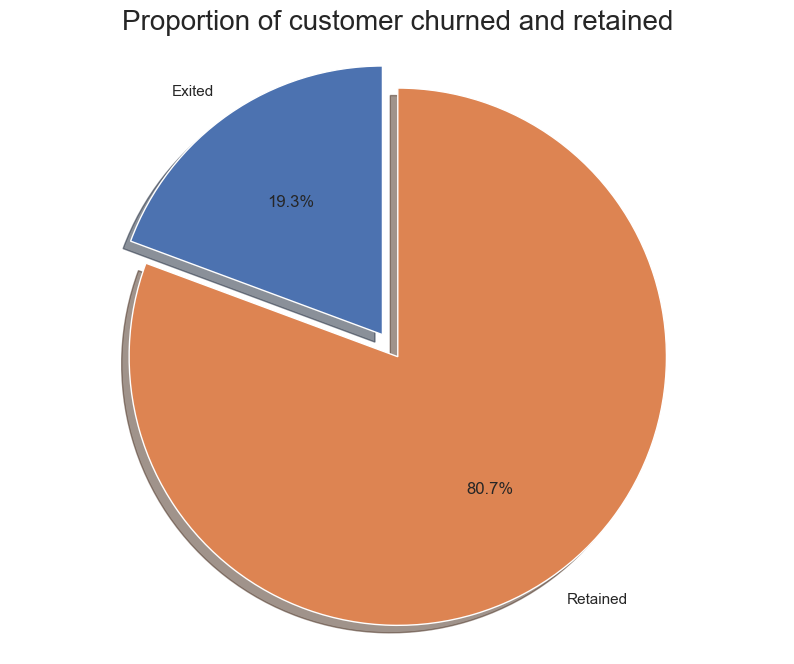

In [117]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

The bank kept approx 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.



## Continuous Variables

In [118]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
print('Continuous: ', ', '.join(continuous))


Continuous:  Age, CreditScore, Balance, EstimatedSalary


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='EstimatedSalary'>

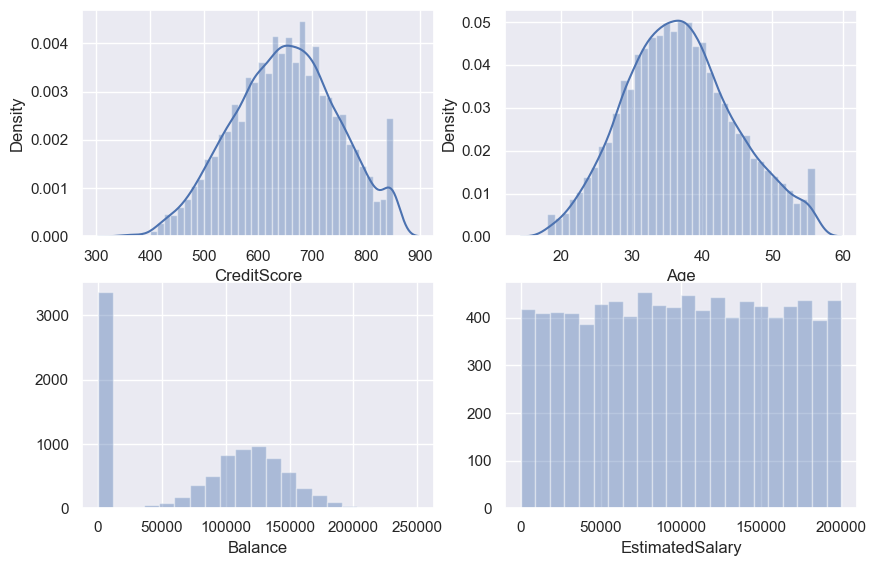

In [119]:
plt.figure(figsize = (10,10))

sns.set(color_codes = True)

plt.subplot(3,2,1)
sns.distplot(df['CreditScore'])

plt.subplot(3,2,2)
sns.distplot(df['Age'])

plt.subplot(3,2,3)
sns.distplot(df['Balance'], kde = False)

plt.subplot(3,2,4)
sns.distplot(df['EstimatedSalary'], kde = False)

**Important Points:**
- *'Age'* is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for *'CreditScore'* are above 600,
- If we ignore the first bin, *'Balance'* follows a fairly normal distribution, and
- The distribution of *'EstimatedSalary'* is more or less uniform and provides little information.

Checking corrleation between Continuous Variables

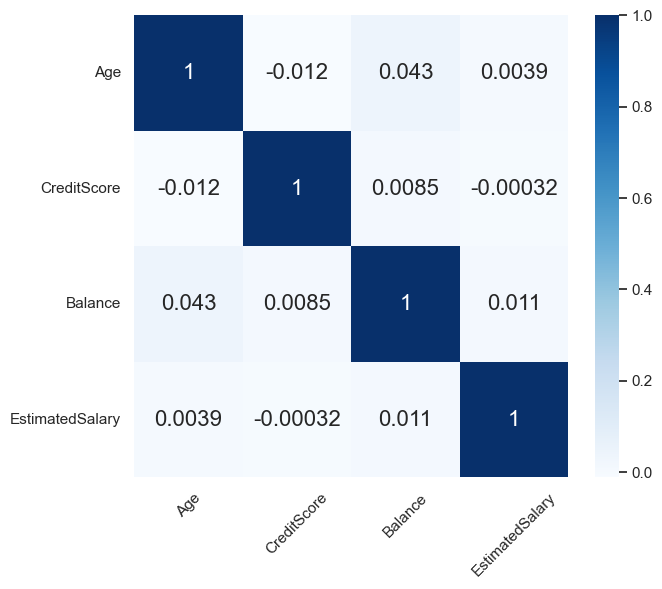

In [120]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

## Categorical Variables

In [121]:

categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts','HasCrCard', 'IsActiveMember']
print('Categorical: ', ', '.join(categorical))

Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

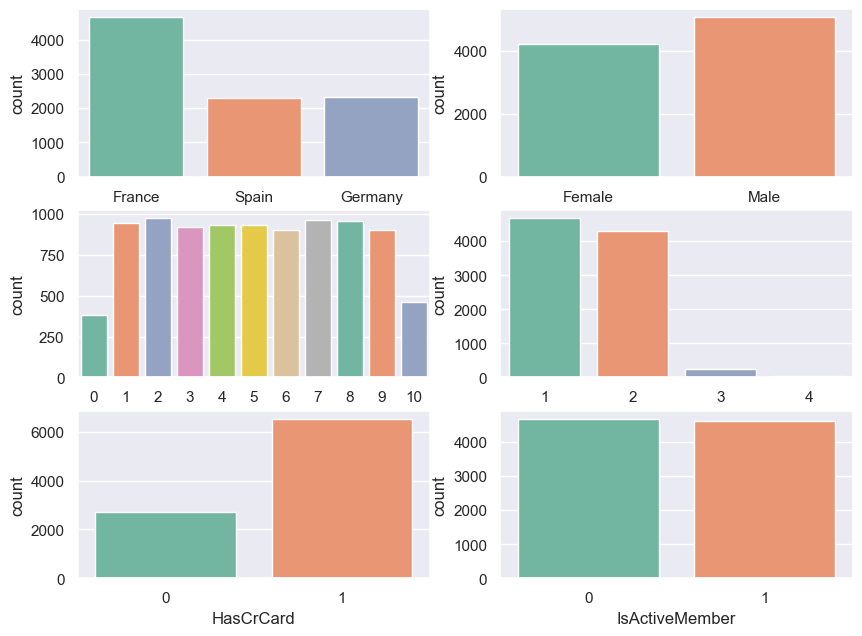

In [122]:
plt.figure(figsize = (10,10))

plt.subplot(4,2,1)
sns.countplot(x = 'Geography', palette='Set2', data = df)

plt.subplot(4,2,2)
sns.countplot(x = 'Gender', palette='Set2', data = df)

plt.subplot(4,2,3)
sns.countplot(x = 'Tenure', palette='Set2', data = df)

plt.subplot(4,2,4)
sns.countplot(x = 'NumOfProducts', palette='Set2', data = df)

plt.subplot(4,2,5)
sns.countplot(x = 'HasCrCard', palette='Set2', data = df)

plt.subplot(4,2,6)
sns.countplot(x = 'IsActiveMember', palette='Set2', data = df)


**Important points:**

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

Checking corrleation between Categorical Variables

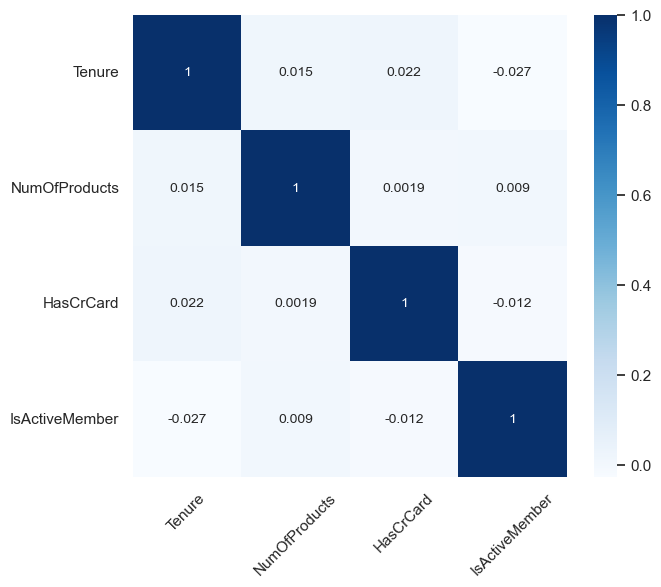

In [123]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df[categorical].corr(),
            annot=True,
            annot_kws={'fontsize': 10},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

## Bivariate Analysis


In our bivariate analysis we were able to get some insights, product 2 despite having a lot of samples generally does not have a churn problem, men and women are well distributed in churn values, and the other variables are also well distributed.

<AxesSubplot:xlabel='Exited', ylabel='count'>

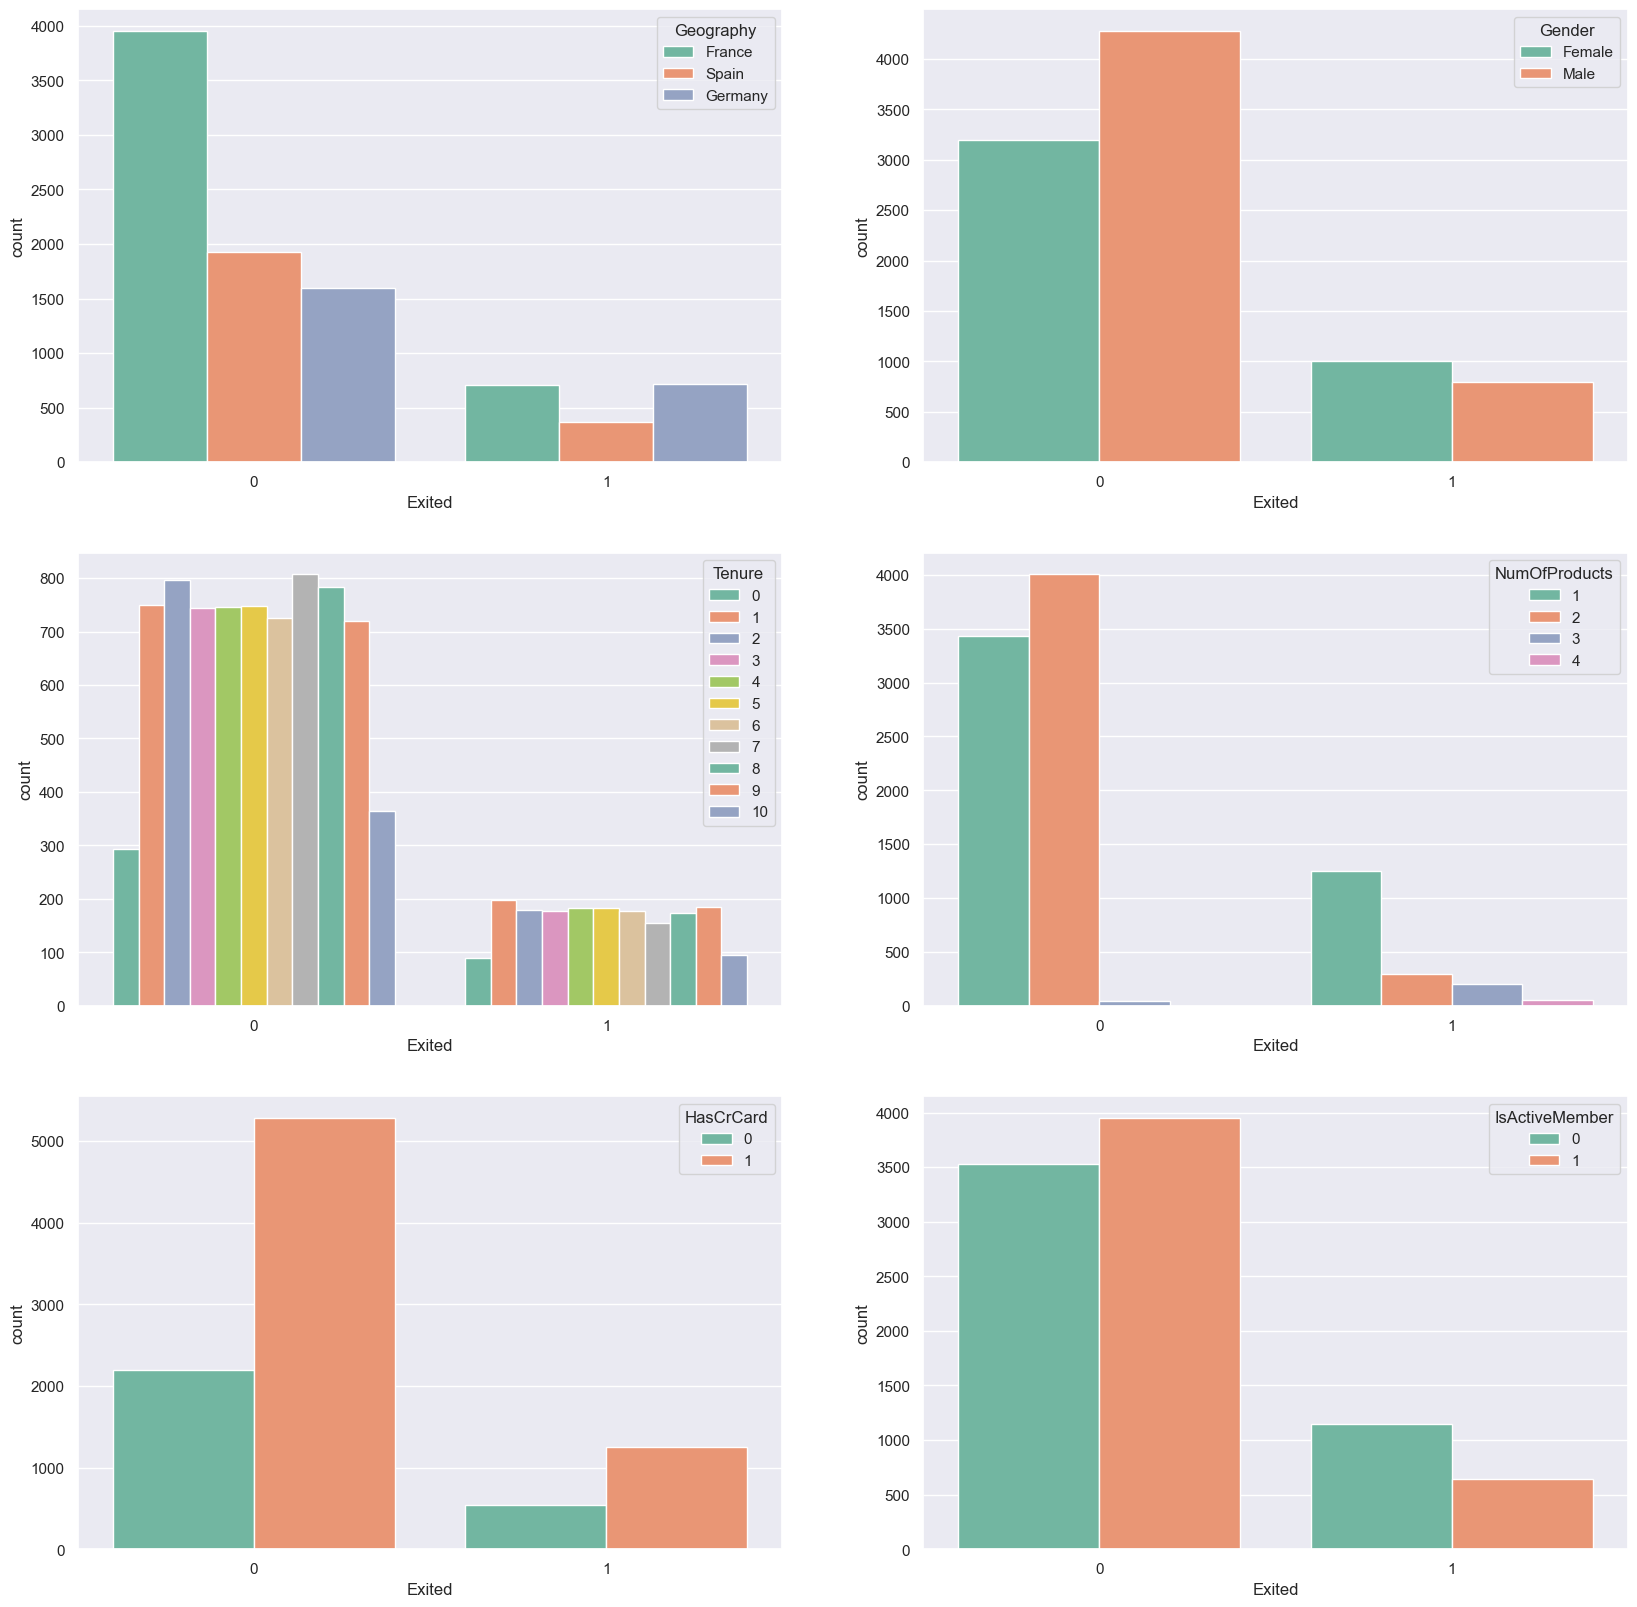

In [124]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
sns.countplot(x = 'Exited', hue= 'Geography', palette='Set2', data = df)

plt.subplot(3,2,2)
sns.countplot(x = 'Exited', hue= 'Gender', palette='Set2', data = df)

plt.subplot(3,2,3)
sns.countplot(x = 'Exited', hue= 'Tenure', palette='Set2', data = df)

plt.subplot(3,2,4)
sns.countplot(x = 'Exited', hue= 'NumOfProducts', palette='Set2', data = df)

plt.subplot(3,2,5)
sns.countplot(x = 'Exited', hue= 'HasCrCard', palette='Set2', data = df)

plt.subplot(3,2,6)
sns.countplot(x = 'Exited', hue= 'IsActiveMember', palette='Set2', data = df)

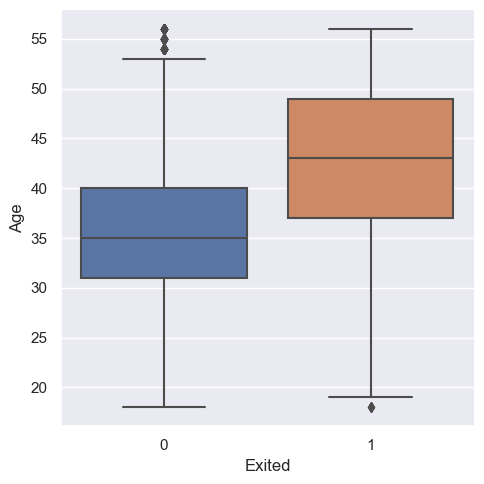

In [125]:
sns.catplot(x = 'Exited', y="Age", kind="box", data = df)

Looking at the age variable, we can see that older people are generally more prone to churn.

## Looking for Correlations


<AxesSubplot:>

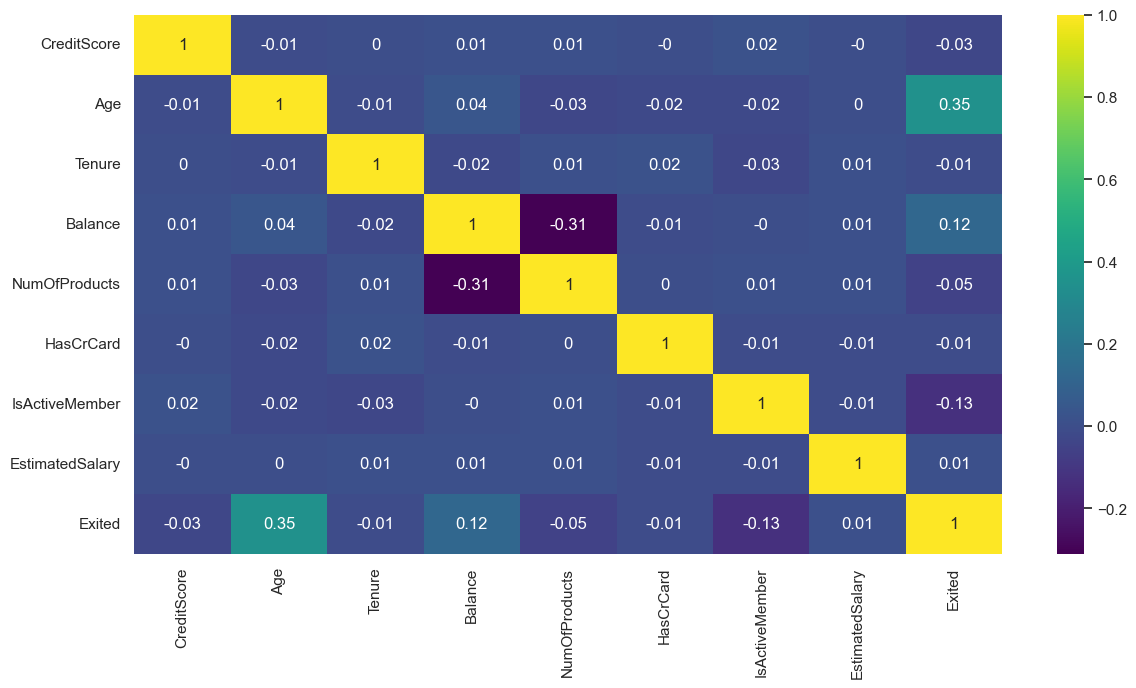

In [126]:
correlation = df.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'viridis')

## Encoding Categorical Features

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before building models.

Our dataset contains two features that require encoding.

- we will use scikit-learn's `LabelEncoder()` which maps each unique label to an integer 
- - For 'Gender' 
- - - (Male --> 1 and Female --> 0).
- - For 'Geography'
- - - (France --> 0 ,Germany --> 1 ,Spain--> 2).



In [128]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Gender'] = labelencoder.fit_transform(df['Gender'])
df['Geography'] = labelencoder.fit_transform(df['Geography'])
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1


## Scaling

Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling, while others are invariant . 

I decided to use **`StandardScaler()`**, which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with zero mean and unit variance.

In [ ]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
df[scl_columns] = scaler.fit_transform(df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


C:\Users\piyus\AppData\Local\Temp\ipykernel_11480\3850683213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[scl_columns] = scaler.fit_transform(df[scl_columns])


### Spliting the data into dependent and independent variables

In [129]:
X = df.drop(columns='Exited', axis=1)
Y = df['Exited']

### Spliting the data in Train and Test

In [133]:
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)


## Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In many tasks in the real world, there is typically a problem with class imbalance. Machine learning algorithms are likely to produce models that do little more than predict the most prevalent class as a result of the bias that results from a classification using imbalanced data in favor of the majority class. Common metrics can also be deceptive when dealing with class-imbalanced data; for instance, a classifier that consistently predicts 0 will have a 99.9% accuracy rate if the dataset contains 99.9% 0s and 0.01% 1s.

 **SMOTE** ('Synthetic Minority Oversampling Technique') was the algorithm we chose to utilize.

In [134]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)


In [135]:
y_train_balanced.value_counts()

0    5967
1    5967
Name: Exited, dtype: int64

# Building the model with appropriate ML algorithms with pre-processed data

### Decision Tree Classifier

In [136]:
dt_model = DecisionTreeClassifier(criterion='entropy')
dt_model.fit(X_train_balanced, y_train_balanced)
pred_dt = dt_model.predict(x_test)
acc_dt = accuracy_score(y_test, pred_dt)
print(acc_dt)
conf_dt = confusion_matrix(y_test,pred_dt)
conf_dt

0.761596548004315


array([[1197,  313],
       [ 129,  215]], dtype=int64)

In [137]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1510
           1       0.41      0.62      0.49       344

    accuracy                           0.76      1854
   macro avg       0.65      0.71      0.67      1854
weighted avg       0.81      0.76      0.78      1854



### Gradient Boosting Classifier

In [138]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train_balanced, y_train_balanced)
pred_gbc = gbc_model.predict(x_test)
acc_gbc = accuracy_score(y_test, pred_gbc)
print(acc_gbc)
conf_gbc = confusion_matrix(y_test,pred_gbc)
conf_gbc


0.796655879180151


array([[1235,  275],
       [ 102,  242]], dtype=int64)

In [139]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1510
           1       0.47      0.70      0.56       344

    accuracy                           0.80      1854
   macro avg       0.70      0.76      0.71      1854
weighted avg       0.84      0.80      0.81      1854



### Random Forest Classifier

In [140]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
pred_rf = rf_model.predict(x_test)
acc_rf = accuracy_score(y_test, pred_rf)
print(acc_rf)
conf_rf = confusion_matrix(y_test,pred_rf)
conf_rf

0.8047464940668824


array([[1274,  236],
       [ 126,  218]], dtype=int64)

In [141]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1510
           1       0.48      0.63      0.55       344

    accuracy                           0.80      1854
   macro avg       0.70      0.74      0.71      1854
weighted avg       0.83      0.80      0.81      1854



### XGB Classifier

In [142]:
xgb_model = XGBClassifier(n_estimators=200)
xgb_model.fit(X_train_balanced, y_train_balanced)
pred_xgb = xgb_model.predict(x_test)
acc_xgb = accuracy_score(y_test, pred_xgb)
print(acc_xgb)
conf_xgb = confusion_matrix(y_test,pred_xgb)
conf_xgb

0.7998921251348435


array([[1262,  248],
       [ 123,  221]], dtype=int64)

In [143]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1510
           1       0.47      0.64      0.54       344

    accuracy                           0.80      1854
   macro avg       0.69      0.74      0.71      1854
weighted avg       0.83      0.80      0.81      1854



### LGBM Classifier

In [157]:
lgbmc_model = LGBMClassifier()
lgbmc_model.fit(X_train_balanced, y_train_balanced)
pred_lgbmc = lgbmc_model.predict(x_test)
acc_lgbmc = accuracy_score(y_test, pred_lgbmc)
print(acc_lgbmc)
conf_lgbmc = confusion_matrix(y_test,pred_lgbmc)
conf_lgbmc

0.8058252427184466


array([[1259,  251],
       [ 109,  235]], dtype=int64)

In [145]:
print(classification_report(y_test, pred_lgbmc))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1510
           1       0.48      0.68      0.57       344

    accuracy                           0.81      1854
   macro avg       0.70      0.76      0.72      1854
weighted avg       0.84      0.81      0.82      1854



In [78]:
df


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1


#### Checking the model with custom inputs

In [152]:
input_data = (502,0,0,42,8,159660.80,3,1,0,113931.57)

# changing input_data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = lgbmc_model.predict(input_data_reshaped)

print(prediction[0])

1


In [153]:
input_data = (608,2,0,41,1,83807.86,1,0,1,112542.58)
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
prediction = lgbmc_model.predict(input_data_reshaped)
print(prediction[0])

0


### Saving the Model

In [158]:
import pickle

In [159]:
# saving the model into the disk
pickle.dump(lgbmc_model, open('model.pkl' , 'wb'))

# loading the model to disk
model = pickle.load(open('model.pkl','rb'))